In [1]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector

25.1351351351 14.5495495495


<IPython.core.display.Javascript object>


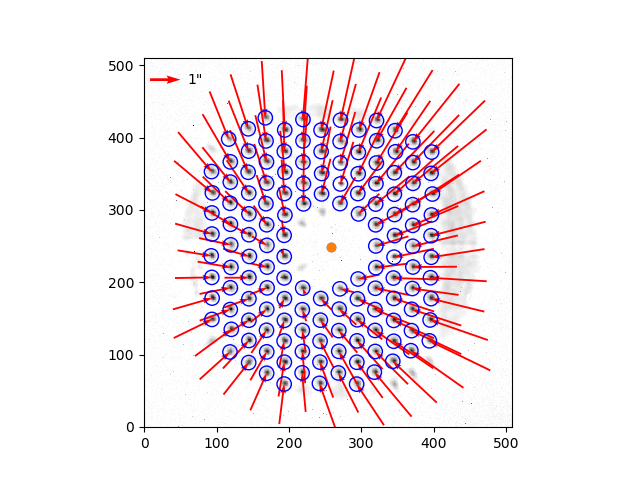

In [2]:
f9wfs = WFSFactory(wfs="f9", nzern=20, h=0.99)
f9_file = "/Users/tim/MMT/wfsdat/20170318/TREY_p500_0000.fits"
results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
plt.show()
# 265 258
# ref 240 259.5

Phase Amplitude Coefficients
 Z02:      -652 nm 	 X Tilt (1, 1)
 Z03: -8.47e+03 nm 	 Y Tilt (1, -1)
 Z04:     -16.8 nm 	 Defocus (2, 0)
 Z05:       108 nm 	 Primary Astig at 45˚ (2, -2)
 Z06:      99.8 nm 	 Primary Astig at 0˚ (2, 2)
 Z07:      32.5 nm 	 Primary Y Coma (3, -1)
 Z08:       -65 nm 	 Primary X Coma (3, 1)
 Z09:      -149 nm 	 Y Trefoil (3, -3)
 Z10:      -664 nm 	 X Trefoil (3, 3)
 Z11:      6.52 nm 	 Primary Spherical (4, 0)
 Z12:       -40 nm 	 Secondary Astigmatism at 0˚ (4, 2)
 Z13:      87.8 nm 	 Secondary Astigmatism at 45˚ (4, -2)
 Z14:     -78.4 nm 	 X Tetrafoil (4, 4)
 Z15:      -113 nm 	 Y Tetrafoil (4, -4)
 Z16:      -162 nm 	 Secondary X Coma (5, 1)
 Z17:     -59.2 nm 	 Secondary Y Coma (5, -1)
 Z18:      68.8 nm 	 Secondary X Trefoil (5, 3)
 Z19:      23.1 nm 	 Secondary Y Trefoil (5, -3)
 Z20:      31.8 nm 	 X Pentafoil (5, 5)
 Z21:       115 nm 	 Y Pentafoil (5, -5)



<IPython.core.display.Javascript object>


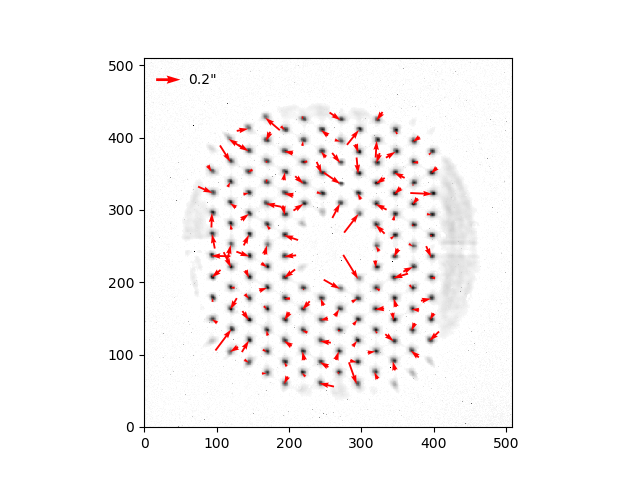

In [3]:
zresults = f9wfs.fit_wavefront(results, plot=True)
print(zresults['zernike'])
plt.show()

<IPython.core.display.Javascript object>


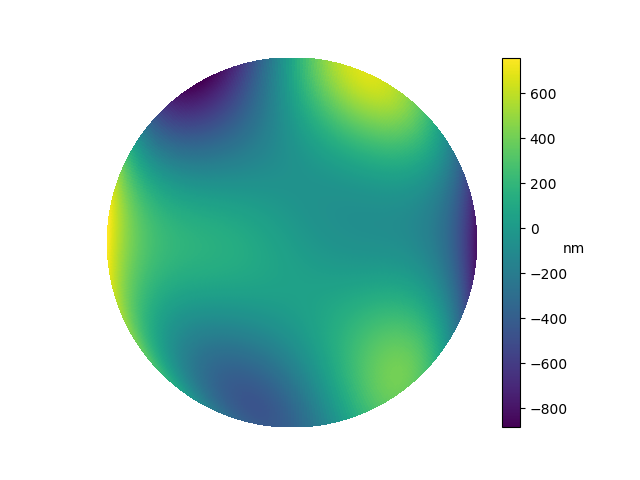

In [4]:
zv = zresults['zernike']
zv.ignore('Z02')
zv.ignore('Z03')
zv.plot_map()
plt.show()

30.4504504505 30.6306306306


<IPython.core.display.Javascript object>


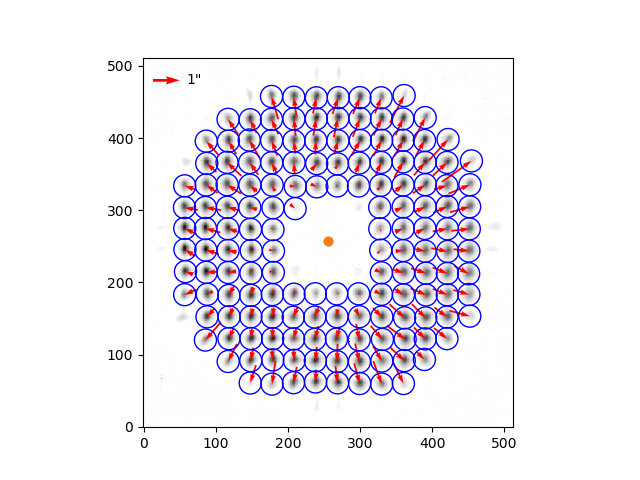

In [5]:
f5wfs = WFSFactory(wfs="f5", nzern=20, back_h=0.99, pup_size=440)
f5_file = "/Users/tim/MMT/wfsdat/20170301/auto_wfs_0037_ave.fits"
results = f5wfs.measure_slopes(f5_file, 'hecto', plot=True)
plt.show()

Phase Amplitude Coefficients
 Z02:  1.05e+03 nm 	 X Tilt (1, 1)
 Z03:      -444 nm 	 Y Tilt (1, -1)
 Z04:       268 nm 	 Defocus (2, 0)
 Z05:      -615 nm 	 Primary Astig at 45˚ (2, -2)
 Z06:       256 nm 	 Primary Astig at 0˚ (2, 2)
 Z07:      11.2 nm 	 Primary Y Coma (3, -1)
 Z08:       227 nm 	 Primary X Coma (3, 1)
 Z09:      74.4 nm 	 Y Trefoil (3, -3)
 Z10:       172 nm 	 X Trefoil (3, 3)
 Z11:     -72.1 nm 	 Primary Spherical (4, 0)
 Z12:     -37.1 nm 	 Secondary Astigmatism at 0˚ (4, 2)
 Z13:      29.1 nm 	 Secondary Astigmatism at 45˚ (4, -2)
 Z14:      81.8 nm 	 X Tetrafoil (4, 4)
 Z15:      -172 nm 	 Y Tetrafoil (4, -4)
 Z16:      8.16 nm 	 Secondary X Coma (5, 1)
 Z17:     -3.31 nm 	 Secondary Y Coma (5, -1)
 Z18:      89.4 nm 	 Secondary X Trefoil (5, 3)
 Z19:     -81.8 nm 	 Secondary Y Trefoil (5, -3)
 Z20:        17 nm 	 X Pentafoil (5, 5)
 Z21:     -4.67 nm 	 Y Pentafoil (5, -5)



<IPython.core.display.Javascript object>


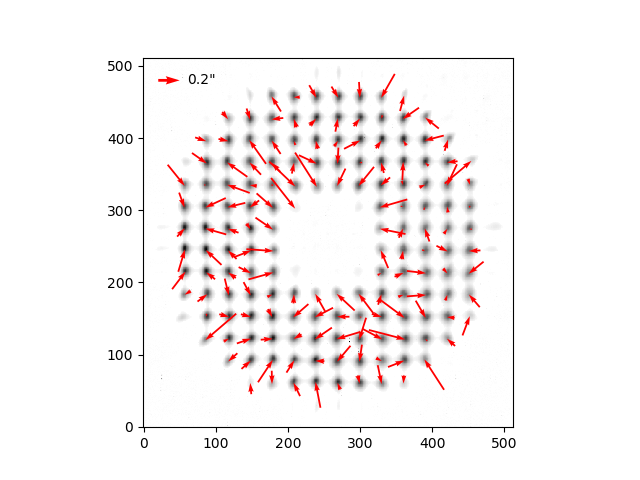

In [6]:
zresults = f5wfs.fit_wavefront(results, plot=True)
zv = zresults['zernike']
print(zv)
plt.show()

240.84267200144842 nm


<IPython.core.display.Javascript object>


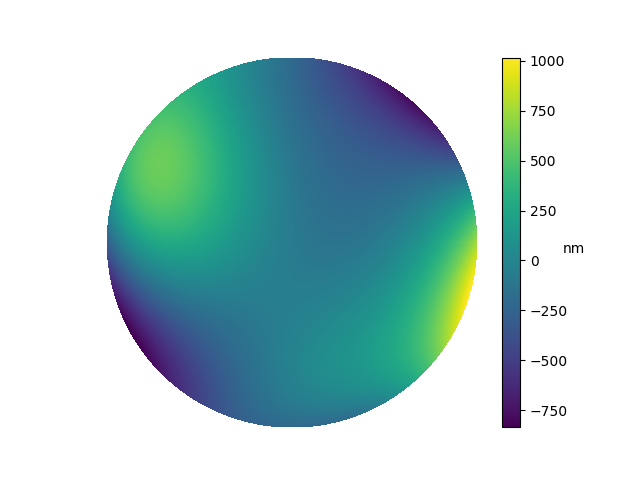

In [7]:
zv.ignore('Z02')
zv.ignore('Z03')
zv.ignore('Z04')
print(zv.rms)
zv.plot_map()
plt.show()

22.0720720721 21.981981982


<IPython.core.display.Javascript object>


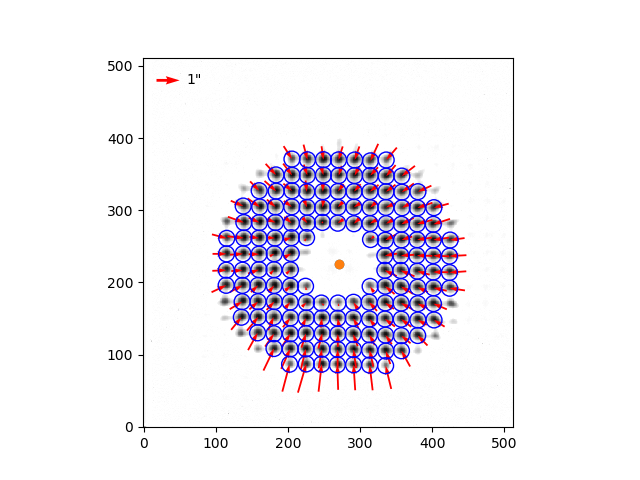

In [8]:
mmirs = WFSFactory(wfs="mmirs", nzern=20, back_h=0.9, pup_size=335)
mmirs_file = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0375.fits"
results = mmirs.measure_slopes(mmirs_file, 'mmirs2', plot=True)
plt.show()

Phase Amplitude Coefficients
 Z02:  -1.2e+03 nm 	 X Tilt (1, 1)
 Z03:  1.49e+03 nm 	 Y Tilt (1, -1)
 Z04:     1e+03 nm 	 Defocus (2, 0)
 Z05:       396 nm 	 Primary Astig at 45˚ (2, -2)
 Z06:     -5.76 nm 	 Primary Astig at 0˚ (2, 2)
 Z07:       126 nm 	 Primary Y Coma (3, -1)
 Z08:       240 nm 	 Primary X Coma (3, 1)
 Z09:      -503 nm 	 Y Trefoil (3, -3)
 Z10:      -295 nm 	 X Trefoil (3, 3)
 Z11:       116 nm 	 Primary Spherical (4, 0)
 Z12:      -316 nm 	 Secondary Astigmatism at 0˚ (4, 2)
 Z13:      25.1 nm 	 Secondary Astigmatism at 45˚ (4, -2)
 Z14:       103 nm 	 X Tetrafoil (4, 4)
 Z15:      -115 nm 	 Y Tetrafoil (4, -4)
 Z16:      41.1 nm 	 Secondary X Coma (5, 1)
 Z17:       125 nm 	 Secondary Y Coma (5, -1)
 Z18:     -41.8 nm 	 Secondary X Trefoil (5, 3)
 Z19:      -120 nm 	 Secondary Y Trefoil (5, -3)
 Z20:     -56.1 nm 	 X Pentafoil (5, 5)
 Z21:      46.4 nm 	 Y Pentafoil (5, -5)



<IPython.core.display.Javascript object>


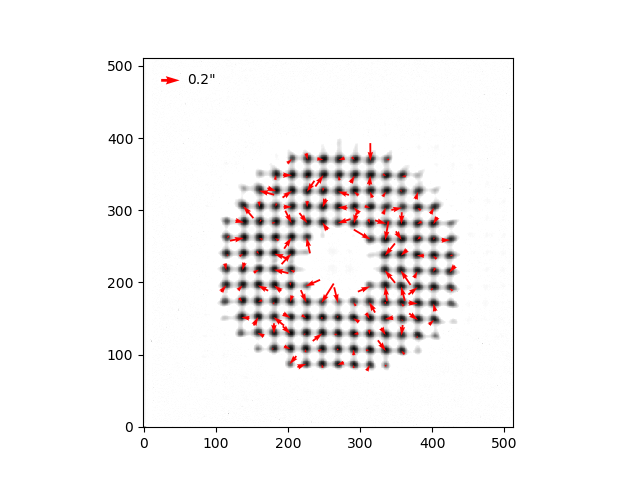

In [9]:
zresults = mmirs.fit_wavefront(results, plot=True)
zv = zresults['zernike']
print(zv)
plt.show()

In [ ]:
zresults['rot_zernike'] - zresults['zernike']

In [ ]:
zv.ignore('Z02')
zv.ignore('Z03')
print(zv.rms)
zv.plot_map()
plt.show()

In [ ]:
pup = f5wfs.pupil_mask(rotator=0)
plt.imshow(pup)
plt.show()

In [ ]:
im = check_wfsdata(f5_file)
back = background(im, h=0.9)
plt.imshow(im-back, origin='lower')
plt.show()

In [ ]:
subt = im - back
fits.writeto("blah.fits", subt, overwrite=True)

In [ ]:
cen = center_pupil(subt, pup, plot=True)
print(cen)
plt.show()

In [ ]:
from astropy.io import ascii

In [10]:
t = f9wfs.telescope
m = t.zern_map

In [11]:
z = np.loadtxt("/Users/tim/MMT/wfsdat/20170110/mmirs_wfs_0375.dao.sub.zrn.cor")

In [12]:
z

array([  4.72444678e+03,  -2.69635742e+04,   6.62513192e+02,
         2.55997589e+02,  -2.70829974e+02,   1.25613262e+02,
        -1.56597419e+02,  -6.76320026e+01,   7.86506782e+01,
         1.48299593e+02,   9.20959470e+00,   7.42381897e+01,
         5.25989532e+01,  -1.53813782e+01,   4.62476997e+01,
         1.86685181e+01,   2.70227375e+01,  -1.07067070e+01,
        -1.39177237e+01])

In [13]:
Z = ZernikeVector(coeffs=z, zmap=m)

In [14]:
Z

Phase Amplitude Coefficients


 Z02:  4.72e+03 nm 	 X Tilt (1, 1)
 Z03:  -2.7e+04 nm 	 Y Tilt (1, -1)
 Z04:       663 nm 	 Defocus (2, 0)
 Z05:       256 nm 	 Primary Astig at 45˚ (2, -2)
 Z06:      -271 nm 	 Primary Astig at 0˚ (2, 2)
 Z07:       126 nm 	 Primary Y Coma (3, -1)
 Z08:      -157 nm 	 Primary X Coma (3, 1)
 Z09:      78.7 nm 	 Y Trefoil (3, -3)
 Z10:       148 nm 	 X Trefoil (3, 3)
 Z11:     -67.6 nm 	 Primary Spherical (4, 0)
 Z12:      74.2 nm 	 Secondary Astigmatism at 0˚ (4, 2)
 Z13:      9.21 nm 	 Secondary Astigmatism at 45˚ (4, -2)
 Z14:     -15.4 nm 	 X Tetrafoil (4, 4)
 Z15:      52.6 nm 	 Y Tetrafoil (4, -4)
 Z16:        27 nm 	 Secondary X Coma (5, 1)
 Z17:     -10.7 nm 	 Secondary Y Coma (5, -1)
 Z18:      46.2 nm 	 Secondary X Trefoil (5, 3)
 Z19:      18.7 nm 	 Secondary Y Trefoil (5, -3)
 Z22:     -13.9 nm 	 Secondary Spherical (6, 0)